importing functions

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from modules import *

## Horner method

### Function 

In [11]:
def horner_eval(coeffs, z):
    """
    Evaluate a polynomial at a given point using Horner's method.
    
    Parameters:
    coeffs (array-like): Coefficients of the polynomial (in ascending order of degree).
    z (float or array-like): Point(s) at which to evaluate the polynomial.
    
    Returns:
    float or ndarray: Value of the polynomial at point(s) z.
    """
    result = coeffs[-1]  # Start with the highest degree coefficient
    for c in reversed(coeffs[:-1]):  # Iterate through remaining coefficients in reverse
        result = result * z + c
    return result

def standard_polynomial_eval(coeffs, z):
    """Standard polynomial evaluation method"""
    result = 0
    for i, coeff in enumerate(coeffs):
        result += coeff * (z ** i)
    return result

### Tests 

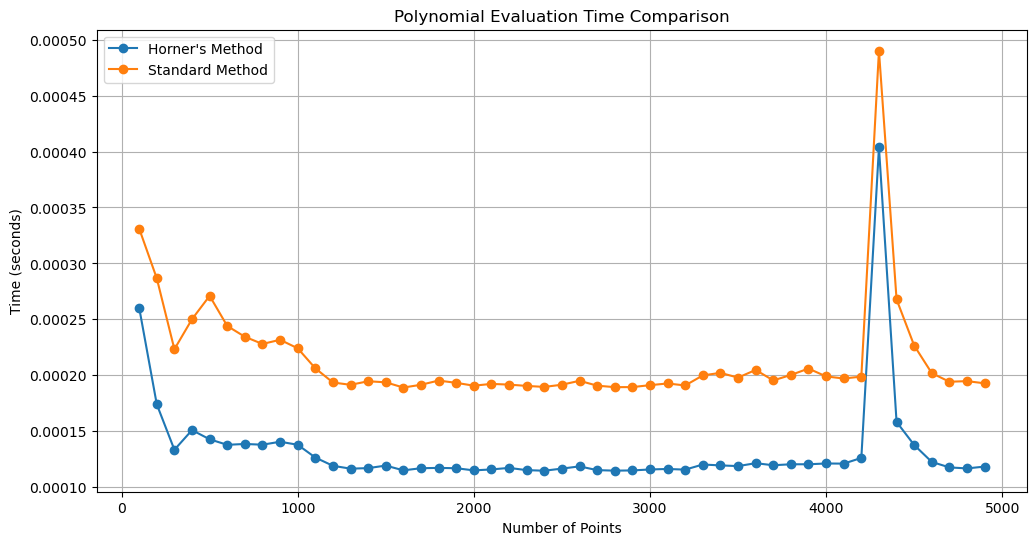

Average time for Horner's method: 0.000133 ± 0.000045
Average time for standard method: 0.000215 ± 0.000049
Speed improvement: 1.62x ± 0.09x


In [48]:
# Test parameters
n_start = 100
n_end = 5000
n_sep = 100
n_points_range = range(n_start, n_end, n_sep)
num_trials = 100
test_point = 1.5

# Lists to store timing results
horner_times = []
standard_times = []
 

for n in n_points_range:
    # list that contains n probe time 
    horner_trial_times = []
    standard_trial_times = []
    for _ in range(num_trials):
        # generating random coeff:
        oeffs = np.random.rand(n) * 100
        
        start_time = datetime.now()
        _ = horner_eval(coeffs, test_point)
        end_time = datetime.now()
        horner_trial_times.append((end_time - start_time).total_seconds())
        
    # Standard method timing
        start_time = datetime.now()
        _ = standard_polynomial_eval(coeffs, test_point)
        end_time = datetime.now()
        standard_trial_times.append((end_time - start_time).total_seconds())
        
    # calculating mean time 
    horner_times.append(np.mean(horner_trial_times))
    standard_times.append(np.mean(standard_trial_times))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(list(n_points_range), horner_times, label="Horner's Method", marker='o')
plt.plot(list(n_points_range), standard_times, label='Standard Method', marker='o')
plt.xlabel('Number of Points')
plt.ylabel('Time (seconds)')
plt.title('Polynomial Evaluation Time Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print statistics
print(f"Average time for Horner's method: {np.mean(horner_times):.6f} ± {np.std(horner_times):.6f}")
print(f"Average time for standard method: {np.mean(standard_times):.6f} ± {np.std(standard_times):.6f}")
print(f"Speed improvement: {np.mean(standard_times)/np.mean(horner_times):.2f}x ± {np.std([x/y for x,y in zip(standard_times, horner_times)]):.2f}x")

## Neville's method

### Function 

In [49]:
def neville(datax, datay, x):
    """
    Evaluate a polynomial at a given point using Neville's method.
    
    Parameters:
    datax (array-like): x-coordinates of the data points.
    datay (array-like): y-coordinates of the data points.
    x (float or array-like): Point(s) at which to evaluate the polynomial.
    
    Returns:
    float or ndarray: Value of the polynomial at point(s) x.
    """
    n = len(datax)
    p = np.array(datay, copy=True)
    for k in range(1, n):
        p[:n-k] = ((x - datax[k:]) * p[:n-k] + (datax[:n-k] - x) * p[1:n-k+1]) / (datax[:n-k] - datax[k:])
    return p[0]

### Tests 

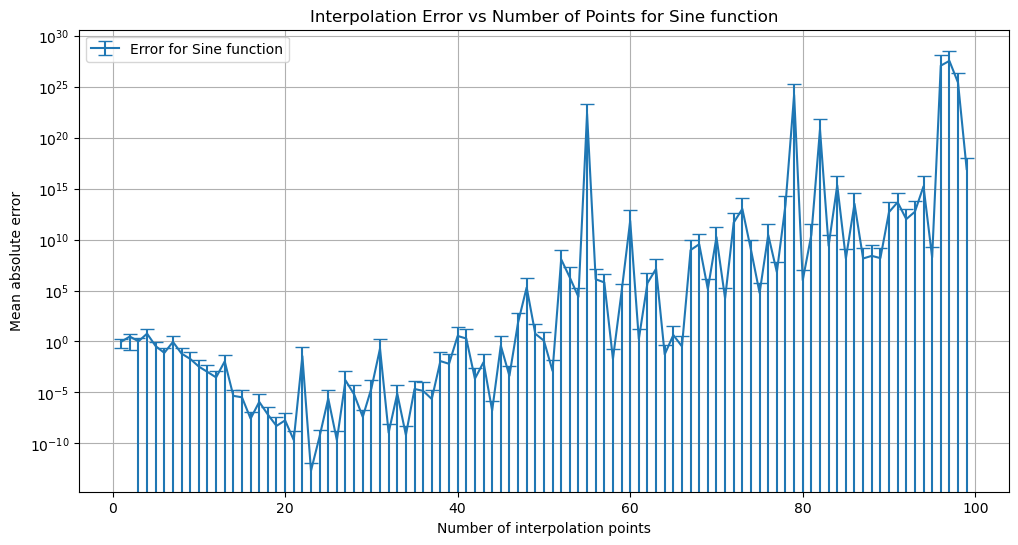

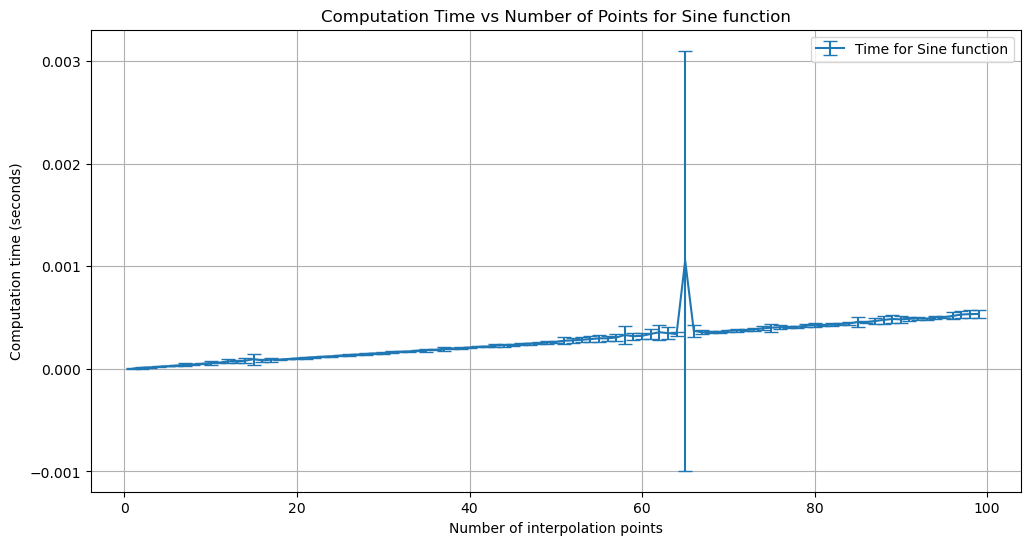


Results for Sine function:
Minimum error: 2.01e-13 ± 1.03e-12
Achieved with 23 points
Average computation time: 0.000274 ± 0.000038 seconds


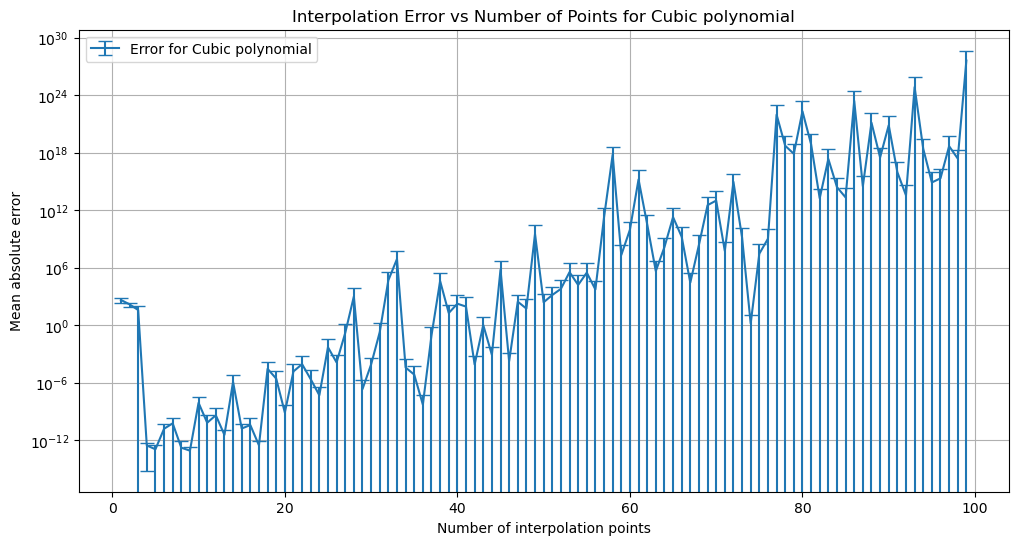

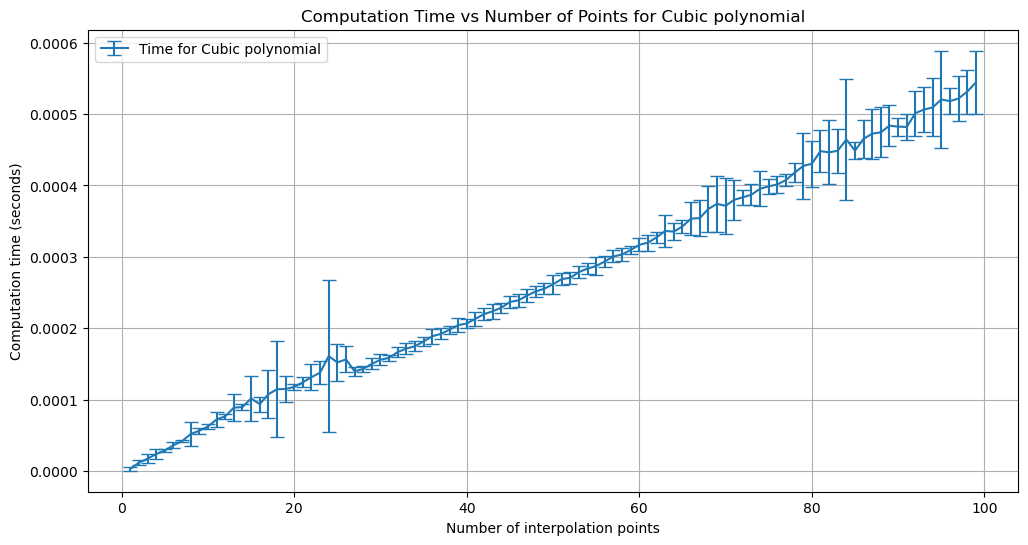


Results for Cubic polynomial:
Minimum error: 8.21e-14 ± 1.31e-13
Achieved with 9 points
Average computation time: 0.000269 ± 0.000018 seconds


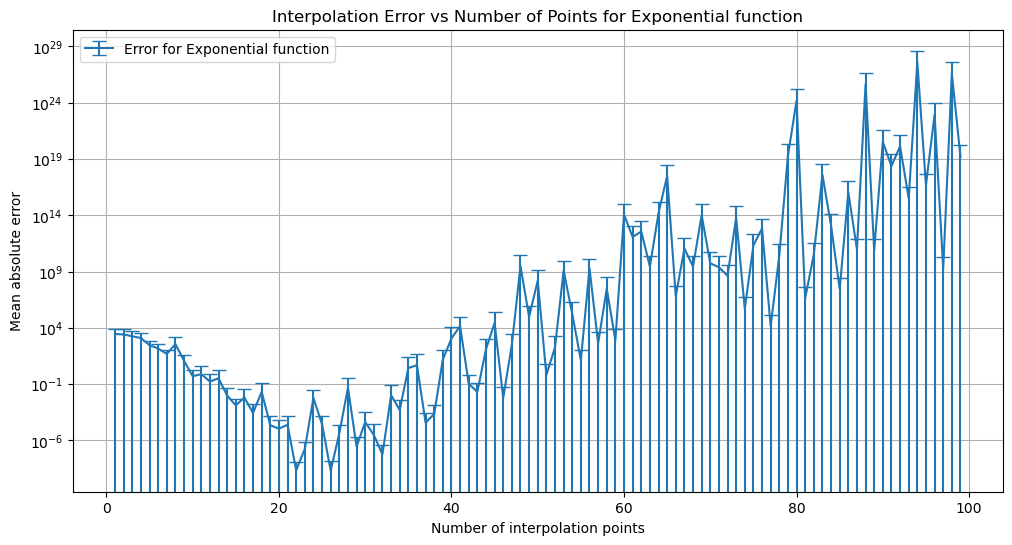

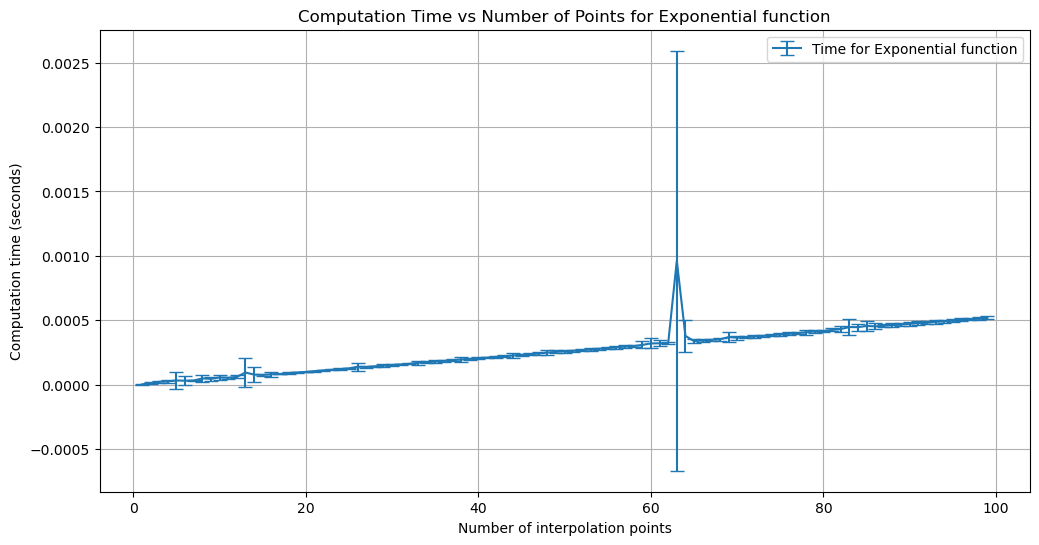


Results for Exponential function:
Minimum error: 2.00e-09 ± 1.25e-08
Achieved with 26 points
Average computation time: 0.000268 ± 0.000032 seconds


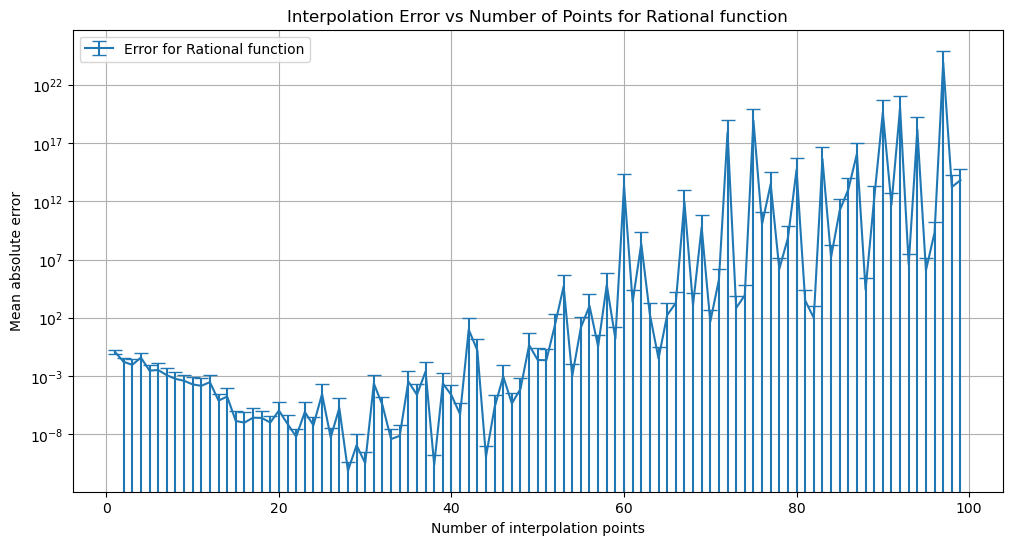

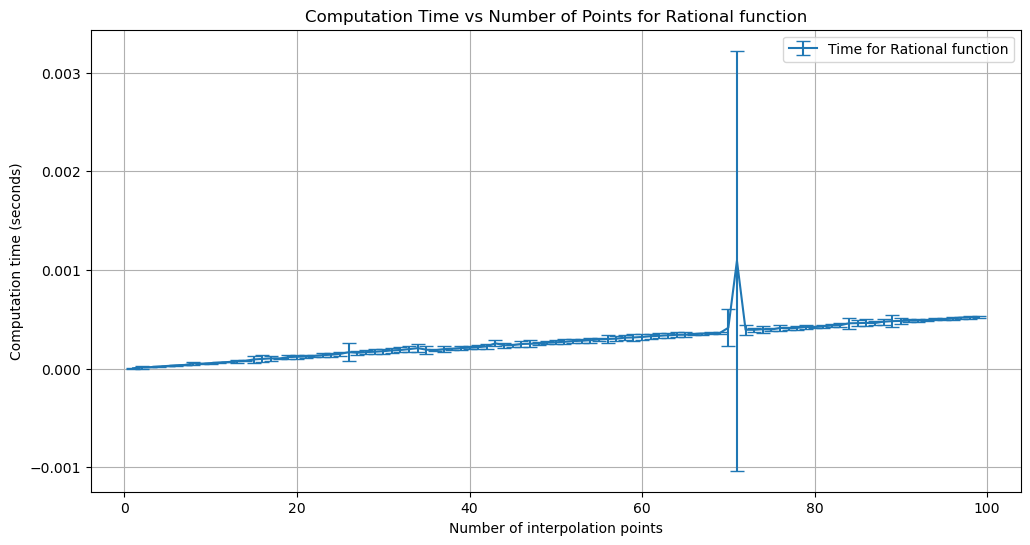


Results for Rational function:
Minimum error: 7.63e-12 ± 3.28e-11
Achieved with 28 points
Average computation time: 0.000278 ± 0.000044 seconds


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

# Test functions to interpolate
def test_functions():
    return {
        'trigonometric': (lambda x: np.sin(x) + np.cos(x) , 'Sine function'),
        'polynomial': (lambda x: x**3 - 2*x + 1, 'Cubic polynomial'),
        'exp': (lambda x: np.exp(x), 'Exponential function'),
        'rational': (lambda x: 1/(1 + x**2), 'Rational function')
    }

def calculate_interpolation_error(func, domain, n_points, test_range):
    """
    Calculate interpolation error for given function and number of points.
    
    Parameters:
    func: callable - Function to interpolate
    domain: tuple - (start, end) of domain
    n_points: int - Number of points to use for interpolation
    test_range: tuple - (start, end, num_points) for testing
    
    Returns:
    tuple - (mean_error, std_error)
    """
    # Generate random points for interpolation
    x_interp = np.sort(np.random.uniform(domain[0], domain[1], n_points))
    y_interp = func(x_interp)
    
    # Generate test points
    x_test = np.linspace(test_range[0], test_range[1], test_range[2])
    y_true = func(x_test)
    
    # Calculate interpolated values
    y_neville = np.array([neville(x_interp, y_interp, x) for x in x_test])
    
    # Calculate errors
    errors = np.abs(y_true - y_neville)
    
    return np.mean(errors), np.std(errors)


def measure_time(func, domain, n_points, num_trials=100):
    """
    Measure time needed for interpolation.
    
    Parameters:
    func: callable - Function to interpolate
    domain: tuple - (start, end) of domain
    n_points: int - Number of points to use
    num_trials: int - Number of trials for averaging
    
    Returns:
    tuple - (mean_time, std_time)
    """
    times = []
    x_interp = np.sort(np.random.uniform(domain[0], domain[1], n_points))
    y_interp = func(x_interp)
    test_point = np.mean(domain)
    
    for _ in range(num_trials):
        start_time = datetime.now()
        _ = neville(x_interp, y_interp, test_point)
        end_time = datetime.now()
        times.append((end_time - start_time).total_seconds())
    
    return np.mean(times), np.std(times)

# Test parameters
domain = (0, 10)
test_range = (0, 10, 100)  # start, end, num_points
n_points_range = range(1, 100, 1)  # different numbers of interpolation points

# Run tests and plot results
for func_name, (func, label) in test_functions().items():
    # Error analysis
    errors = [calculate_interpolation_error(func, domain, n, test_range) 
             for n in n_points_range]
    mean_errors, std_errors = zip(*errors)
    
    plt.figure(figsize=(12, 6))
    plt.errorbar(n_points_range, mean_errors, yerr=std_errors, 
                label=f'Error for {label}', capsize=5)
    plt.xlabel('Number of interpolation points')
    plt.ylabel('Mean absolute error')
    plt.title(f'Interpolation Error vs Number of Points for {label}')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Time analysis
    times = [measure_time(func, domain, n) for n in n_points_range]
    mean_times, std_times = zip(*times)
    
    plt.figure(figsize=(12, 6))
    plt.errorbar(n_points_range, mean_times, yerr=std_times, 
                label=f'Time for {label}', capsize=5)
    plt.xlabel('Number of interpolation points')
    plt.ylabel('Computation time (seconds)')
    plt.title(f'Computation Time vs Number of Points for {label}')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Print summary statistics
    min_error_idx = np.argmin(mean_errors)
    print(f"\nResults for {label}:")
    print(f"Minimum error: {mean_errors[min_error_idx]:.2e} ± {std_errors[min_error_idx]:.2e}")
    print(f"Achieved with {n_points_range[min_error_idx]} points")
    print(f"Average computation time: {np.mean(mean_times):.6f} ± {np.mean(std_times):.6f} seconds")